# Trabajo práctico 1: Bayes Ingenuo
En el presente trabajo práctico se introduce la implementación de redes
bayesianas. El trabajo practico consta de 120 puntos, donde 20 son extra
## Integrantes
- Marco Ferraro

In [45]:
import torch
import torchvision
from PIL import Image
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
import torchvision.datasets as datasets
import torchvision.transforms as transformst
import torchvision.transforms as transforms

In [46]:
# Set default tensor type to CUDA if available
if torch.cuda.is_available():
    print("CUDA is available! Training on GPU...")
    torch.set_default_tensor_type(torch.cuda.FloatTensor)

## Implementación de la clasiﬁcación multiclase de imágenes con Bayes ingenuo usando histogramas

Para el presente ejercicio, se implementará la clasiﬁcación de imagenes
naturales con K = 10 clases. La Figura 1 muestra algunas observaciones
del conjunto de datos. El objetivo de su equipo de desarrollo es utilizar el teorema de Bayes para construir un modelo conocido como Bayes
ingenuo, el cual permita estimar la clase a la que pertenece una nueva
observación



### Carga de datos Cifar-10

Para la carga de datos se utilizó la librería cifar10, la cual contiene un conjunto de datos de 50,000 imágenes de 32x32 pixeles en 10 clases diferentes. Se utilizará en escalado de grises para simplificar el problema.

In [47]:
"""
    Carga el conjunto de datos CIFAR-10, convierte las imágenes a escala de grises y las agrupa en un tensor.

    Esta función descarga el conjunto de datos CIFAR-10, aplica una transformación para convertir las imágenes
    a escala de grises y luego agrupa todas las imágenes en un tensor único. También prepara un tensor con las
    etiquetas correspondientes a cada imagen.

    Parámetros:
    - is_train (bool, opcional): Un booleano que indica si se deben cargar los datos de entrenamiento (True) o
      los datos de prueba (False). Por defecto es True.

    Retorna:
    - cifar_trainset_tensor (Tensor): Un tensor que contiene todas las imágenes del conjunto de datos CIFAR-10
      convertidas a escala de grises y redondeadas a valores enteros en el rango de 0 a 255. Las imágenes están
      agrupadas en un tensor único a lo largo de la dimensión del lote.
    - cifar_labels (Tensor): Un tensor que contiene las etiquetas correspondientes a cada imagen en el tensor
      de imágenes.
"""


def load_cifar10_dataset(is_train=True):
  # Define a transformation to convert images to grayscale
  transforms_1 = transforms.Compose([
      transforms.ToTensor(),
      transforms.Grayscale(num_output_channels=1)  # Convert to grayscale
  ])
  cifar_trainset = datasets.CIFAR10(
      root='./data', train=is_train, download=True, transform=transforms_1)

  # Initialize an empty list to store batches
  all_data = []
  train_loader = torch.utils.data.DataLoader(
      cifar_trainset, batch_size=64, shuffle=True)
  # Iterate over the train_loader to fetch all batches
  for batch in train_loader:
      images, _ = batch  # Extract images from the batch
      all_data.append(images)

  # Concatenate all batches into a single tensor along the batch dimension
  cifar_trainset_tensor = torch.round(torch.cat(all_data, dim=0) * 255)
  cifar_labels = torch.tensor(cifar_trainset.targets)
  print("cifar_trainset_tensor shape ", cifar_trainset_tensor.shape)
  print("cifar_labels ", cifar_labels.shape)
  return (cifar_trainset_tensor, cifar_labels)


train_tensor, train_labels = load_cifar10_dataset(is_train=True)

train_tensor[1][0]

Files already downloaded and verified
cifar_trainset_tensor shape  torch.Size([50000, 1, 32, 32])
cifar_labels  torch.Size([50000])


tensor([[246., 244., 244.,  ..., 232., 239., 243.],
        [246., 245., 245.,  ..., 240., 244., 245.],
        [240., 238., 239.,  ..., 244., 244., 243.],
        ...,
        [ 83.,  76.,  74.,  ..., 132., 139., 140.],
        [ 96.,  89.,  89.,  ..., 137., 135., 133.],
        [120., 114.,  96.,  ..., 132., 133., 133.]])

In [48]:
train_tensor.shape

torch.Size([50000, 1, 32, 32])

In [49]:
train_labels.shape

torch.Size([50000])

Graficamos una imagen para visualizar y comprender el dataset. 

torch.Size([32, 32])


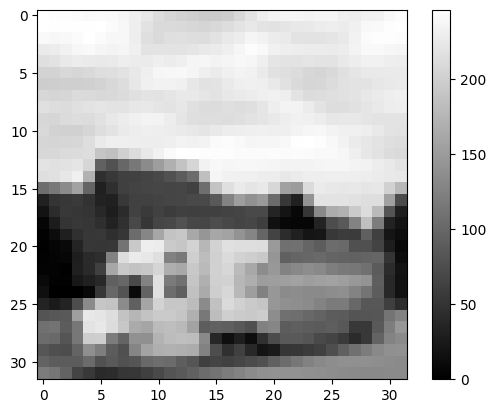

In [50]:
import matplotlib.pyplot as plt
import torch

# Asumiendo que train_tensor[1][0] es tu tensor de imagen en escala de grises
image_tensor = train_tensor[1][0]

print(image_tensor.shape)

# Verifica si el tensor está en un dispositivo CUDA y muévelo a CPU
if image_tensor.is_cuda:
    image_tensor = image_tensor.cpu()

# Convierte el tensor a un arreglo de numpy
image_numpy = image_tensor.numpy()

# Dado que es en escala de grises, elimina la dimensión del canal si existe
if image_tensor.dim() > 2:
    image_numpy = image_numpy.squeeze(0)

# Grafica la imagen
plt.imshow(image_numpy, cmap='gray')
plt.colorbar()
plt.show()

In [51]:
image_tensor = train_tensor
image_labels = train_labels

### Caluclo a priori p(t) para las clases

Implemente el cálculo de las probabilidades a priori p (t)
para las K = 10 clases en el conjunto de datos de entrenamiento en
la función calcular_probabilidad_priori. Realice tal calculo dentro de la
funcion train_model.

In [52]:
import torch

"""
Calcula las probabilidades a priori de etiquetas únicas en un conjunto de datos.

Args:
    labels (list o torch.Tensor): Etiquetas para calcular las probabilidades.

Returns:
    tuple (torch.Tensor, torch.Tensor): Probabilidades de cada etiqueta y etiquetas únicas.
"""


def calculate_priori_p_t(labels):
    # Convertir labels a un tensor si aún no lo es
    labels_tensor = torch.tensor(labels) if not isinstance(
        labels, torch.Tensor) else labels

    # Contar las ocurrencias de cada etiqueta
    label_counts = labels_tensor.bincount()

    # Calcular probabilidades dividiendo por el número total de etiquetas
    probabilities = label_counts.float() / labels_tensor.size(0)

    # Generar un tensor de etiquetas únicas ordenadas
    unique_labels = torch.arange(label_counts.size(0))

    # Filtrar etiquetas con conteo cero
    nonzero_indices = label_counts.nonzero().squeeze()
    probabilities = probabilities[nonzero_indices]
    unique_labels = unique_labels[nonzero_indices]

    return probabilities, unique_labels


# Ejemplo de uso de la función
# Asegúrate de definir 'labels' antes de llamar a la función
probabilities, unique_labels = calculate_priori_p_t(train_labels)

print("Probabilities:", probabilities)
print("Unique labels:", unique_labels)
print("Sum of probabilities:", probabilities.sum())
print("Shape of probabilities:", probabilities.shape)

Probabilities: tensor([0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
        0.1000])
Unique labels: tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
Sum of probabilities: tensor(1.0000)
Shape of probabilities: torch.Size([10])


Vemos que por defecto, todas las clases tienen la misma probabilidad a priori. Esto significa que estan balanceadas. Esto va a ser modificado en la seccion de entrenamiento.

In [53]:
import torch


# Prueba con etiquetas consecutivas
consecutive_labels = torch.tensor([0, 1, 1, 2, 2, 2])
consecutive_probabilities, consecutive_unique_labels = calculate_priori_p_t(
    consecutive_labels)

assert torch.allclose(consecutive_probabilities, torch.tensor(
    [1/6, 2/6, 3/6])), "Probabilities do not match"
assert torch.equal(consecutive_unique_labels, torch.tensor(
    [0, 1, 2])), "Unique labels do not match"

# Prueba con etiquetas no consecutivas
non_consecutive_labels = torch.tensor([0, 0, 2, 2, 2, 5, 5, 5, 5])
non_consecutive_probabilities, non_consecutive_unique_labels = calculate_priori_p_t(
    non_consecutive_labels)

assert torch.allclose(non_consecutive_probabilities, torch.tensor(
    [2/9, 3/9, 4/9])), "Probabilities do not match"
assert torch.equal(non_consecutive_unique_labels, torch.tensor(
    [0, 2, 5])), "Unique labels do not match"

print("All tests passed successfully.")

All tests passed successfully.


In [54]:
def calculate_marginal_probabilities(data, dim=0):
    # Calculate the marginal probabilities
    marginal_probabilities = data[dim].sum() / data.sum()
    return marginal_probabilities

In [55]:
Mock_data = torch.Tensor([[20.0, 70.0, 80.0, 10.0], [40.0, 10.0, 30.0, 5.0]])

print(calculate_marginal_probabilities(Mock_data, dim=0))
print(calculate_marginal_probabilities(Mock_data, dim=1))


tensor(0.6792)
tensor(0.3208)


In [56]:
def calculate_conditional_probabilities(data):
    # Calculate the conditional probabilities
    n_classes = data.shape[0]

    p_tensor = torch.zeros(data.shape)

    for i in range(n_classes):
        row_sum = data[i].sum()
        p_tensor[i] = data[i] / row_sum

    return p_tensor

p_tensor = calculate_conditional_probabilities(Mock_data)

print("Probabilities for class 0: ", p_tensor[0])
print("Probabilities for class 1: ", p_tensor[1])


Probabilities for class 0:  tensor([0.1111, 0.3889, 0.4444, 0.0556])
Probabilities for class 1:  tensor([0.4706, 0.1176, 0.3529, 0.0588])


In [57]:
import torch

"""
Calcula la matriz de probabilidad de las densidades de cada pixel para cada intensidad de pixel posible y para cada clase.

Args:
    images (torch.Tensor): Un tensor de imágenes con dimensiones [N, C, H, W], donde N es el número de imágenes, C es el número de canales, H es la altura y W es la anchura.
    normalize (bool, opcional): Si se debe normalizar la matriz de probabilidad tal que la suma de probabilidades de cada valor de pixel a través de todas las posiciones sea 1. Por defecto es False.

Returns:
    torch.Tensor: Un tensor de dimensiones [D, Z, K], donde D es el número de densidades (H*W), Z es el número máximo de intensidades de pixel posibles (255 máximo), y K es el número de clases. Cada columna corresponde a la densidad de cada pixel.
"""


def calculate_probability_matrix(images, normalize=False):
    min_pixel_value = int(images.min().item())
    max_pixel_value = int(images.max().item())
    num_pixel_values = max_pixel_value - \
        min_pixel_value + 1  # +1 because range is inclusive

    H, W = images.shape[2], images.shape[3]
    images_flattened = images.view(-1, H * W)

    # Create a range tensor of all possible pixel values
    range_tensor = torch.arange(
        min_pixel_value, max_pixel_value + 1, dtype=torch.float32, device=images.device)

    # Expand dimensions to allow broadcasting
    expanded_images = images_flattened.unsqueeze(2)  # Shape: [N*H*W, 1]
    expanded_range = range_tensor.unsqueeze(0).unsqueeze(
        0)  # Shape: [1, 1, num_pixel_values]

    # Use broadcasting to create a mask where each pixel value equals the range value
    mask = expanded_images == expanded_range

    # Sum over the first dimension to get histogram counts across all images and positions
    # Shape: [H*W, num_pixel_values]
    pixel_value_counts = mask.sum(dim=0, dtype=torch.float32)

    # Transpose to match the expected output shape
    # Shape: [num_pixel_values, H*W]
    pixel_value_counts = pixel_value_counts.t()

    probability_matrix = pixel_value_counts / images.shape[0]

    if normalize:
        # Normalize such that the sum of probabilities for each pixel value across all positions is 1
        probability_matrix = probability_matrix / \
            probability_matrix.sum(dim=1, keepdim=True)

    return probability_matrix.view(num_pixel_values, H, W)


def calculate_class_probabilities(train_data, labels, num_classes=3, normalize=False):
    class_probabilities = []

    for class_id in range(num_classes):
        class_indices = torch.where(labels == class_id)[0]
        class_images = train_data[class_indices]
        probability_matrix = calculate_probability_matrix(
            class_images, normalize=normalize)
        class_probabilities.append(probability_matrix)

    final_probability_tensor = torch.stack(class_probabilities, dim=0)
    return final_probability_tensor


# Ejemplo de uso
train_data = torch.randint(254, 256, (50000, 1, 32, 32), dtype=torch.uint8)
labels = torch.randint(0, 3, (50000,), dtype=torch.long)
final_probability_tensor = calculate_class_probabilities(
    train_data, labels, normalize=True)

print(final_probability_tensor.shape)  # Debería ser [3, 256, 32, 32]
print(final_probability_tensor)        # Este es tu tensor de resultado
# El resultado será 1 si la normalización se hace correctamente
# Ahora debería retornar correctamente 1
print(final_probability_tensor[1][0].sum())

torch.Size([3, 2, 32, 32])
tensor([[[[0.0010, 0.0010, 0.0010,  ..., 0.0010, 0.0010, 0.0010],
          [0.0010, 0.0010, 0.0010,  ..., 0.0010, 0.0010, 0.0010],
          [0.0010, 0.0010, 0.0010,  ..., 0.0010, 0.0010, 0.0010],
          ...,
          [0.0010, 0.0010, 0.0010,  ..., 0.0010, 0.0010, 0.0010],
          [0.0010, 0.0010, 0.0010,  ..., 0.0010, 0.0010, 0.0010],
          [0.0010, 0.0010, 0.0010,  ..., 0.0010, 0.0010, 0.0010]],

         [[0.0010, 0.0010, 0.0010,  ..., 0.0010, 0.0010, 0.0010],
          [0.0010, 0.0010, 0.0010,  ..., 0.0010, 0.0010, 0.0010],
          [0.0010, 0.0010, 0.0010,  ..., 0.0010, 0.0010, 0.0010],
          ...,
          [0.0010, 0.0010, 0.0010,  ..., 0.0010, 0.0010, 0.0010],
          [0.0010, 0.0010, 0.0010,  ..., 0.0010, 0.0010, 0.0010],
          [0.0010, 0.0010, 0.0010,  ..., 0.0010, 0.0010, 0.0010]]],


        [[[0.0010, 0.0010, 0.0010,  ..., 0.0010, 0.0010, 0.0010],
          [0.0010, 0.0010, 0.0010,  ..., 0.0010, 0.0010, 0.0010],
          [0.

In [58]:
import torch


def calculate_probability_matrix(images, normalize=False):
    min_pixel_value = int(images.min().item())
    max_pixel_value = int(images.max().item())
    num_pixel_values = max_pixel_value - min_pixel_value + 1

    H, W = images.shape[2], images.shape[3]
    images_flattened = images.view(-1, H * W)

    range_tensor = torch.arange(
        min_pixel_value, max_pixel_value + 1, dtype=torch.float32, device=images.device)
    expanded_images = images_flattened.unsqueeze(2)
    expanded_range = range_tensor.unsqueeze(0).unsqueeze(0)

    mask = expanded_images == expanded_range
    pixel_value_counts = mask.sum(dim=0, dtype=torch.float32)
    pixel_value_counts = pixel_value_counts.t()

    probability_matrix = pixel_value_counts / images.shape[0]

    if normalize:
        probability_matrix = probability_matrix / \
            probability_matrix.sum(dim=1, keepdim=True)

    return probability_matrix.view(num_pixel_values, H, W)


def calculate_class_probabilities(train_data, labels, num_classes=3, normalize=False):
    class_probabilities = []

    for class_id in range(num_classes):
        class_indices = torch.where(labels == class_id)[0]
        class_images = train_data[class_indices]
        probability_matrix = calculate_probability_matrix(
            class_images, normalize=normalize)
        class_probabilities.append(probability_matrix)

    final_probability_tensor = torch.stack(class_probabilities, dim=0)
    return final_probability_tensor


# Ejemplo de uso
train_data = torch.randint(0, 256, (50000, 1, 32, 32), dtype=torch.uint8)
labels = torch.randint(0, 3, (50000,), dtype=torch.long)
final_probability_tensor = calculate_class_probabilities(
    train_data, labels, normalize=True)

print(final_probability_tensor.shape)  # Debería ser [3, 256, 32, 32]
print(final_probability_tensor)        # Este es tu tensor de resultado
print(final_probability_tensor[1][0].sum())  # Verificación de normalización

torch.Size([3, 256, 32, 32])
tensor([[[[0.0009, 0.0009, 0.0010,  ..., 0.0010, 0.0010, 0.0010],
          [0.0010, 0.0009, 0.0007,  ..., 0.0009, 0.0011, 0.0011],
          [0.0010, 0.0011, 0.0008,  ..., 0.0009, 0.0009, 0.0009],
          ...,
          [0.0010, 0.0007, 0.0008,  ..., 0.0010, 0.0010, 0.0010],
          [0.0011, 0.0011, 0.0010,  ..., 0.0009, 0.0011, 0.0010],
          [0.0008, 0.0009, 0.0007,  ..., 0.0009, 0.0011, 0.0010]],

         [[0.0010, 0.0010, 0.0009,  ..., 0.0011, 0.0010, 0.0009],
          [0.0011, 0.0010, 0.0009,  ..., 0.0010, 0.0009, 0.0008],
          [0.0010, 0.0008, 0.0008,  ..., 0.0008, 0.0008, 0.0012],
          ...,
          [0.0012, 0.0010, 0.0010,  ..., 0.0009, 0.0013, 0.0009],
          [0.0008, 0.0012, 0.0010,  ..., 0.0009, 0.0009, 0.0010],
          [0.0010, 0.0011, 0.0009,  ..., 0.0012, 0.0010, 0.0010]],

         [[0.0008, 0.0010, 0.0012,  ..., 0.0010, 0.0008, 0.0010],
          [0.0009, 0.0010, 0.0009,  ..., 0.0012, 0.0009, 0.0010],
          [0.

In [59]:
"""
    Entrena un modelo generando histogramas de densidades de clase a partir de los datos de entrenamiento.

    Esta función calcula las probabilidades a priori de cada clase y las densidades de los datos de entrenamiento
    para cada clase. Luego, aplana las densidades de los datos para simplificar su estructura.

    Args:
    - train_data (Tensor): Un tensor que contiene los datos de entrenamiento. Se espera que tenga la forma
      adecuada para el modelo que se está entrenando.
    - train_labels (Tensor): Un tensor que contiene las etiquetas de los datos de entrenamiento. Cada etiqueta
      debe corresponder a los datos en `train_data`.
    - normalize (bool, opcional): Un booleano que indica si se deben normalizar las densidades de los datos.
      Por defecto es True.

    Returns:
    - dataset_densities (Tensor): Un tensor que contiene las densidades de los datos de entrenamiento
      para cada clase. Las densidades están aplanadas para simplificar su estructura.
    - priori_p_k (Tensor): Un tensor que contiene las probabilidades a priori de cada clase basadas en
      las etiquetas de entrenamiento.
"""

def train_model_histogram(train_data, train_labels, normalize=True):
    priori_p_k, unique_labels = calculate_priori_p_t(train_labels)

    dataset_densities = calculate_class_probabilities(train_data, train_labels, num_classes=len(
        unique_labels), normalize=normalize)
    
    dataset_densities = torch.flatten(dataset_densities, start_dim=2, end_dim=3)
    print("dataset_densities shape ", dataset_densities.shape)


    return dataset_densities, priori_p_k


dataset_densities, priori_p_k = train_model_histogram(train_tensor, train_labels, normalize=False)

print(dataset_densities.shape)
print(dataset_densities[0][0].sum())

dataset_densities shape  torch.Size([10, 256, 1024])
torch.Size([10, 256, 1024])
tensor(1.3468)


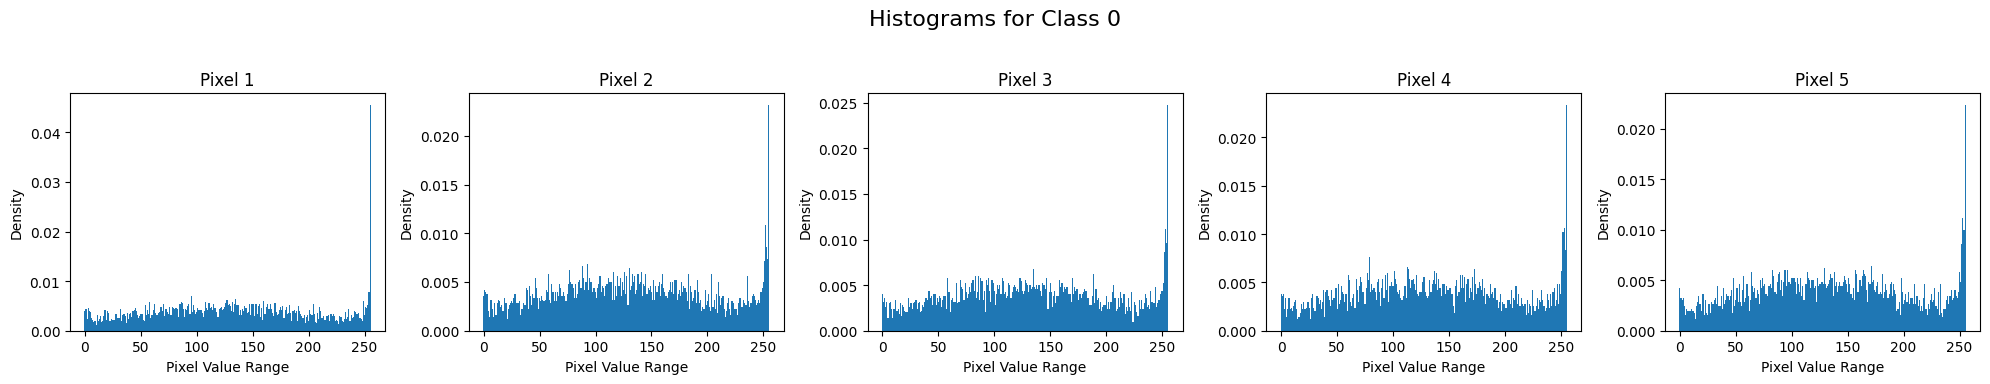

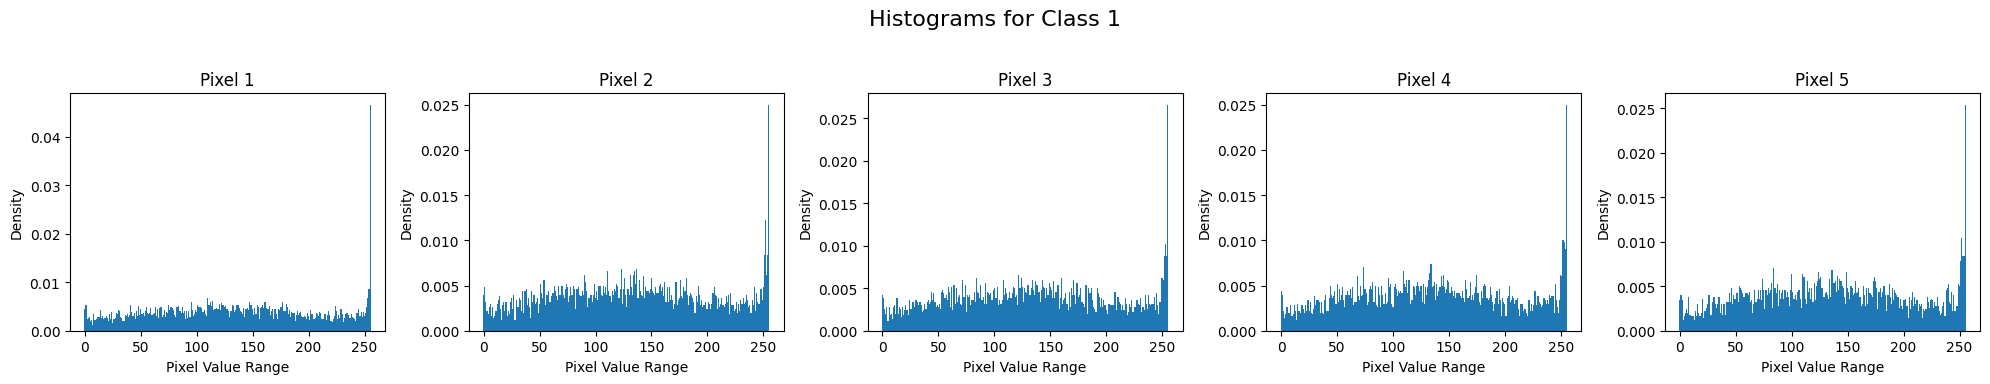

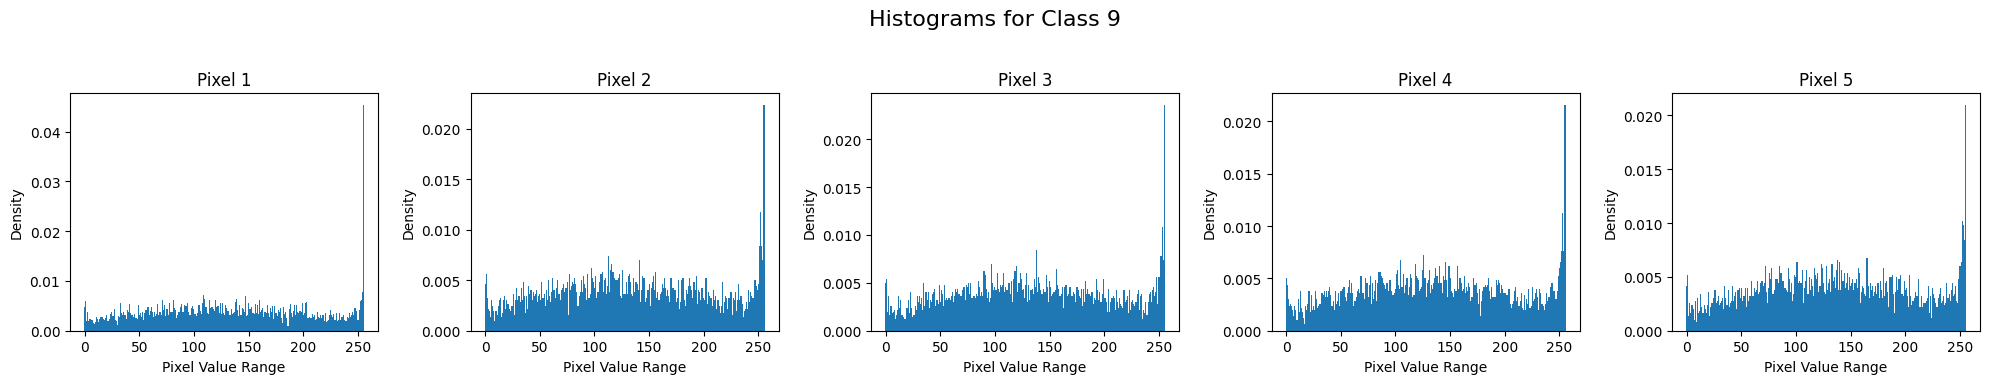

In [60]:
import matplotlib.pyplot as plt
import numpy as np
import torch  # Assuming you're using PyTorch tensors

"""
    Grafica histogramas para el número especificado de píxeles de una clase dada.

    Parámetros:
    - dataset_densities: Un tensor con forma [num_classes, 256, num_pixels].
    - class_index: El índice de la clase para la cual se graficarán los histogramas.
    - num_pixels: El número de píxeles para los cuales se graficarán histogramas.
    - bins: El número de contenedores para agrupar los valores de los píxeles.

    Esta función convierte el tensor a un arreglo de numpy si es un tensor de PyTorch, extrae las densidades
    para la clase especificada, calcula los bordes y anchos de los contenedores para la agregación y grafica
    histogramas para el número especificado de píxeles. Cada histograma muestra la densidad de los valores de
    píxeles dentro de rangos específicos para un píxel dado.
"""
def plot_pixel_densities(dataset_densities, class_index=0, num_pixels=5, bins=16):
    # Convertir el tensor a un arreglo numpy si es un tensor de PyTorch
    if isinstance(dataset_densities, torch.Tensor):
        dataset_densities = dataset_densities.numpy()

    # Extraer las densidades para la clase especificada
    class_densities = dataset_densities[class_index]

    # Calculate bin edges and widths for aggregation
    bin_edges = np.linspace(0, 256, bins + 1)
    bin_width = bin_edges[1] - bin_edges[0]

    # Graficar histogramas para el número especificado de píxeles
    fig, axs = plt.subplots(1, num_pixels, figsize=(20, 4))
    for i in range(num_pixels):
        pixel_densities = class_densities[:, i]
        # Agregar densidades de píxeles en contenedores
        binned_densities = np.histogram(
            np.arange(256), bins=bin_edges, weights=pixel_densities)[0]
        axs[i].bar(bin_edges[:-1], binned_densities, width=bin_width)
        axs[i].set_title(f'Pixel {i+1}')
        axs[i].set_xlabel('Pixel Value Range')
        axs[i].set_ylabel('Density')

    fig.suptitle(f'Histograms for Class {class_index}', fontsize=16)

    # Ajustar el diseño para hacer espacio para el título
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


# Ejemplo de uso
plot_pixel_densities(dataset_densities, class_index=0, num_pixels=5, bins=256)
plot_pixel_densities(dataset_densities, class_index=1, num_pixels=5, bins=256)
plot_pixel_densities(dataset_densities, class_index=9, num_pixels=5, bins=256)

In [61]:
import numpy as np
from collections import Counter

def test_model_histogram(input_torch, dataset_densities, priori_p_k):
    # Calculate the log-likelihoods


    likelihood_image = []
    likelihoods_class = torch.zeros(dataset_densities.shape[0])
    num_pixel = 0

    for pixel in input_torch:
        pixel_value = int(pixel.item())

        for i in range(dataset_densities.shape[0]):
            #likelihoods_class[i] += (torch.log(dataset_densities[i][pixel_value][num_pixel]) + torch.log(priori_p_k[i]))
            likelihoods_class[i] += ((dataset_densities[i][pixel_value][num_pixel]) * (priori_p_k[i]))


        likelihood_image.append(torch.argmax(likelihoods_class).item())
        likelihoods_class = torch.zeros(dataset_densities.shape[0])

        num_pixel += 1

    counter = Counter(likelihood_image)
    return counter.most_common(1)[0][0]

test_specific_image = train_tensor[150][0]
# Hacemos flatten a la imagen para que los pixeles esten ubicados en una sola dimension.
test_specific_image = torch.flatten(test_specific_image)
print(test_specific_image)

test_specific_target = image_labels[150]
print("The target label is: ", test_specific_target.item())

pred = test_model_histogram(test_specific_image, dataset_densities, priori_p_k)
print("The predicted label is: ", pred)

tensor([160., 159., 159.,  ..., 151., 151., 154.])
The target label is:  3
The predicted label is:  3


In [62]:
def test_model_batch_histogram(test_set, labels, dataset_densities, p_t_tensor):
  y_truth = labels
  y_pred = torch.zeros(len(labels))
  i = 0

  cont = True

  for tensor_image in test_set:
    tensor_image = torch.flatten(tensor_image)
    img_pred = test_model_histogram(tensor_image, dataset_densities, p_t_tensor)
    y_pred[i] = img_pred

    print("The target label is: ", y_truth[i].item())
    print("The predicted label is: ", y_pred[i].item())
    #print("")

    i += 1


  #print("y_pred ", y_pred)
  #print("y_truth ", y_truth)
  y_pred = y_pred.int()


  correct_predictions = (y_pred == y_truth)
  #print("correct_predictions ", correct_predictions)

  print(torch.sum(correct_predictions).item())
  accuracy = torch.sum(correct_predictions).item() / len(labels)

  return accuracy, y_pred, y_truth

In [63]:
test_tensor, test_labels = load_cifar10_dataset(is_train=False)

test_tensor = test_tensor[0:350]
test_labels = test_labels[0:350]

accuracy,  y_pred, y_truth = test_model_batch_histogram(
    test_tensor, test_labels, dataset_densities, priori_p_k)

print("Accuracy: ", accuracy)

Files already downloaded and verified
cifar_trainset_tensor shape  torch.Size([10000, 1, 32, 32])
cifar_labels  torch.Size([10000])
The target label is:  3
The predicted label is:  0.0
The target label is:  8
The predicted label is:  0.0
The target label is:  8
The predicted label is:  5.0
The target label is:  0
The predicted label is:  0.0
The target label is:  6
The predicted label is:  1.0
The target label is:  6
The predicted label is:  0.0
The target label is:  1
The predicted label is:  3.0
The target label is:  6
The predicted label is:  3.0
The target label is:  3
The predicted label is:  0.0
The target label is:  1
The predicted label is:  0.0
The target label is:  0
The predicted label is:  0.0
The target label is:  9
The predicted label is:  0.0
The target label is:  5
The predicted label is:  0.0
The target label is:  7
The predicted label is:  3.0
The target label is:  9
The predicted label is:  0.0
The target label is:  8
The predicted label is:  0.0
The target label is:

In [64]:
from sklearn.model_selection import train_test_split
test_tensor_np = test_tensor.numpy()
test_labels_np = test_labels.numpy()



X_train, X_test, y_train, y_test = train_test_split(test_tensor_np, test_labels_np, test_size=0.1, random_state=42)

X_train = torch.from_numpy(X_train)
X_test = torch.from_numpy(X_test)
y_train = torch.from_numpy(y_train)
y_test = torch.from_numpy(y_test)


dataset_densities, priori_p_k = train_model_histogram(
    X_train, y_train, normalize=False)

accuracy,  y_pred, y_truth = test_model_batch_histogram(
    X_test, y_test, dataset_densities, priori_p_k)

print("Accuracy: ", accuracy)

dataset_densities shape  torch.Size([10, 256, 1024])
The target label is:  9
The predicted label is:  0.0
The target label is:  6
The predicted label is:  0.0
The target label is:  0
The predicted label is:  0.0
The target label is:  8
The predicted label is:  0.0
The target label is:  5
The predicted label is:  0.0
The target label is:  8
The predicted label is:  0.0
The target label is:  6
The predicted label is:  0.0
The target label is:  4
The predicted label is:  0.0
The target label is:  4
The predicted label is:  0.0
The target label is:  8
The predicted label is:  0.0
The target label is:  2
The predicted label is:  0.0
The target label is:  8
The predicted label is:  0.0
The target label is:  5
The predicted label is:  0.0
The target label is:  8
The predicted label is:  0.0
The target label is:  8
The predicted label is:  0.0
The target label is:  5
The predicted label is:  0.0
The target label is:  0
The predicted label is:  0.0
The target label is:  3
The predicted label is

In [65]:
y_pred[5]

tensor(0, dtype=torch.int32)

In [66]:
y_truth[5]

tensor(8)